In [1]:
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from typing import NamedTuple
from itertools import product
import json
import math

In [3]:
cols = ["ts_event", "publisher_id", "ask_px_00", "ask_sz_00"]
df = pd.read_csv(
    "l1_day.csv",
    usecols=cols,
    parse_dates=["ts_event"],
    dtype={
        "publisher_id": "int32",
        "ask_px_00":   "float64",
        "ask_sz_00":   "int32",
    },
)

df.sort_values(["ts_event", "publisher_id"], inplace=True)

df = df.drop_duplicates(subset=["ts_event", "publisher_id"], keep="first")

print(df.head())
print('\n-------------------------------------------------------------------------\n')
print(f'L1 Snapshot Shape: {df.shape}')

                             ts_event  publisher_id  ask_px_00  ask_sz_00
0 2024-08-01 13:36:32.491911683+00:00             2     222.83         36
4 2024-08-01 13:36:32.491912675+00:00             2     222.83         46
5 2024-08-01 13:36:32.491927912+00:00             2     222.83        146
6 2024-08-01 13:36:32.491939846+00:00             2     222.82         87
7 2024-08-01 13:36:32.491944432+00:00             2     222.82         87

-------------------------------------------------------------------------

L1 Snapshot Shape: (54537, 4)


In [4]:
class Venue(NamedTuple):
    ask: float
    ask_size: int
    fee: float
    rebate: float

In [5]:
def compute_cost(split, venues, order_size,
                 lambd_over, lambd_under, theta):

    split = np.asarray(split, dtype=np.int32)
    ask = np.fromiter((v.ask for v in venues), dtype=np.float64)
    ask_size = np.fromiter((v.ask_size  for v in venues), dtype=np.int32)
    fee = np.fromiter((v.fee for v in venues), dtype=np.float64)
    rebate = np.fromiter((v.rebate for v in venues), dtype=np.float64)

    executed = np.minimum(split, ask_size)
    maker_vol = split - executed

    cash_spent = (executed * (ask + fee)).sum()
    cash_spent -= (maker_vol * rebate).sum()

    executed_total = int(executed.sum())

    underfill = max(order_size - executed_total, 0)
    overfill = max(executed_total - order_size, 0)

    risk_pen = theta * (underfill + overfill)
    cost_pen = (lambd_under * underfill) + (lambd_over * overfill)

    return cash_spent + risk_pen + cost_pen

In [6]:
def allocate(order_size, venues,
             lambd_over, lambd_under, theta_queue,
             step: int = 100):

    N = len(venues)
    if order_size <= 0 or N == 0:
        return [0] * N, 0.0

    ask = np.fromiter((v.ask for v in venues), dtype=np.float64)
    ask_size = np.fromiter((v.ask_size for v in venues), dtype=np.int32)
    fee = np.fromiter((v.fee for v in venues), dtype=np.float64)
    rebate = np.fromiter((v.rebate for v in venues), dtype=np.float64)

    def _cost(split_arr: np.ndarray) -> float:
        exe = np.minimum(split_arr, ask_size)
        maker = split_arr - exe
        cash = (exe * (ask + fee)).sum() - (maker * rebate).sum()
        executed_total = int(exe.sum())
        under = max(order_size - executed_total, 0)
        over = max(executed_total - order_size, 0)
        return cash + theta_queue*(under + over) \
                    + lambd_under*under + lambd_over*over

    splits = [[]]
    for v in range(N):
        new_splits = []
        for alloc in splits:
            used = sum(alloc)
            max_v = order_size - used
            if max_v < 0:
                continue
            for q in range(0, max_v + step, step):
                new_splits.append(alloc + [q])
        splits = new_splits

    residual = order_size % step
    if residual:
        for alloc in splits:
            alloc[-1] += residual

    best_cost  = float("inf")
    best_split = None

    for alloc in splits:
        if sum(alloc) != order_size:
            continue
        cost = _cost(np.asarray(alloc, dtype=np.int32))
        if cost < best_cost:
            best_cost, best_split = cost, alloc

    if best_split is None:
        cheapest = int(ask.argmin())
        best_split = [0] * N
        best_split[cheapest] = order_size
        best_cost = _cost(np.array(best_split, dtype=np.int32))

    return best_split, float(best_cost)

In [7]:
def load_snapshots(dataf, taker_fee, maker_rebate):
    for ts_event, snap in dataf.groupby("ts_event", sort=True):
        venues = [
            Venue(float(px), int(sz), taker_fee, maker_rebate)
            for px, sz in zip(snap["ask_px_00"], snap["ask_sz_00"])
        ]
        yield ts_event, venues

def run_router(dataf,
               lam_o: float,
               lam_u: float,
               theta_q: float,
               order_size: int = 5_000,
               taker_fee: float = 0.0030,
               maker_rebate: float = 0.0020):

    remaining      = order_size
    cash_spent     = 0.0
    last_best_ask  = None

    for _, venues in load_snapshots(dataf, taker_fee, maker_rebate):
        split, _ = allocate(remaining, venues, lam_o, lam_u, theta_q)

        ask_sz = np.fromiter((v.ask_size for v in venues), dtype=np.int32)
        ask_px = np.fromiter((v.ask      for v in venues), dtype=np.float64)

        exe = np.minimum(split, ask_sz)
        cash_spent += np.sum(exe * (ask_px + taker_fee))

        maker_vol = np.array(split) - exe
        cash_spent -= np.sum(maker_vol * maker_rebate)

        remaining -= int(exe.sum())
        last_best_ask = ask_px.min()

        if remaining <= 0:
            break

    if remaining > 0:
        if last_best_ask is None:
            raise RuntimeError("No snapshots available to execute any shares.")
        cash_spent += remaining * (last_best_ask + taker_fee)

    avg_px = cash_spent / order_size
    return cash_spent, avg_px

In [8]:
L_OVER  = [0.00050, 0.00100, 0.00150, 0.00200, 0.00250]
L_UNDER = [0.00100, 0.00200, 0.00300, 0.00400, 0.00500]
THETA   = [0.00050, 0.00100, 0.00150, 0.00200, 0.00250]

def tune_router(df):
    best_px = float("inf")
    best_cash = None
    best_params = None

    for lambd_over, lambd_under, theta_queue in product(L_OVER, L_UNDER, THETA):
        cash, px = run_router(df, lambd_over, lambd_under, theta_queue)
        if px < best_px:
            best_px, best_cash = px, cash
            best_params = (lambd_over, lambd_under, theta_queue)

    return best_params, best_cash, best_px

In [9]:
best_params, router_cash, router_px = tune_router(df)
print("Best params:", best_params, "avg_px:", router_px)

Best params: (0.0005, 0.001, 0.0005) avg_px: 222.79488559999996


In [10]:
def bestask_baseline(df,
                     order_size: int = 5_000,
                     taker_fee: float = 0.0030) -> tuple[float, float]:
    remaining, cash_spent = order_size, 0.0

    for _, venues in load_snapshots(df, taker_fee, 0.0):
        best_ask = min(v.ask for v in venues)
        vol      = min(remaining, order_size)
        cash_spent += vol * (best_ask + taker_fee)
        remaining  -= vol
        if remaining <= 0:
            break

    avg_px = cash_spent / order_size
    return cash_spent, avg_px

def twap_baseline(df,
                  bucket_secs: int = 60,
                  order_size: int = 5_000,
                  taker_fee: float = 0.0030) -> tuple[float, float]:
    bucket_ns = bucket_secs * 1_000_000_000
    remaining = order_size
    cash_spent = 0.0
    current_bucket = None
    bucket_target = order_size / 9

    for ts, venues in load_snapshots(df, taker_fee, 0.0):
        ts_ns = ts.value if isinstance(ts, pd.Timestamp) else int(ts)

        if current_bucket is None:
            current_bucket = ts_ns // bucket_ns

        if ts_ns // bucket_ns > current_bucket:
            current_bucket = ts_ns // bucket_ns
            slices_left   = max(1, 9 - current_bucket)
            bucket_target = remaining / slices_left

        best_ask = min(v.ask for v in venues)
        vol = min(bucket_target, remaining)
        cash_spent += vol * (best_ask + taker_fee)
        remaining -= vol
        if remaining <= 0:
            break

    if remaining > 0:
        cash_spent += remaining * (best_ask + taker_fee)

    avg_px = cash_spent / order_size
    return cash_spent, avg_px

def vwap_baseline(df,
                  order_size: int = 5_000,
                  taker_fee: float = 0.0030) -> tuple[float, float]:
    remaining, cash_spent = order_size, 0.0

    for _, venues in load_snapshots(df, taker_fee, 0.0):
        ask_px = np.array([v.ask for v in venues], dtype=np.float64)
        ask_sz = np.array([v.ask_size for v in venues], dtype=np.int32)

        weights = ask_sz / ask_sz.sum()
        vwap = float(np.dot(weights, ask_px))

        vol = min(remaining, order_size)
        cash_spent += vol * (vwap + taker_fee)
        remaining -= vol
        if remaining <= 0:
            break

    if remaining > 0:
        cash_spent += remaining * (vwap + taker_fee)

    avg_px = cash_spent / order_size
    return cash_spent, avg_px

In [11]:
ba_cash, ba_px = bestask_baseline(df)
tw_cash, tw_px = twap_baseline(df)
vw_cash, vw_px = vwap_baseline(df)

print("Best‑Ask avg_px:", ba_px)
print("TWAP‑60s avg_px:", tw_px)
print("VWAP avg_px:", vw_px)

Best‑Ask avg_px: 222.833
TWAP‑60s avg_px: 222.82633333333325
VWAP avg_px: 222.833


In [12]:
assert best_params is not None, "Run tune_router() first"
assert router_cash is not None, "Run tune_router() first"
assert ba_cash is not None, "Run baseline cells first"

summary = {
    "lambda_over": best_params[0],
    "lambda_under": best_params[1],
    "theta_queue": best_params[2],

    "router_total_cash": round(router_cash, 2),
    "router_avg_px": round(router_px,   6),

    "bestask_total_cash": round(ba_cash, 2),
    "bestask_avg_px": round(ba_px,   6),

    "twap_total_cash": round(tw_cash, 2),
    "twap_avg_px": round(tw_px,   6),

    "vwap_total_cash": round(vw_cash, 2),
    "vwap_avg_px": round(vw_px,   6),

    "bps_vs_bestask": round(1e4 * (ba_px - router_px) / ba_px, 2),
    "bps_vs_twap": round(1e4 * (tw_px - router_px) / tw_px, 2),
    "bps_vs_vwap": round(1e4 * (vw_px - router_px) / vw_px, 2)
}

print(json.dumps(summary, indent=2))

{
  "lambda_over": 0.0005,
  "lambda_under": 0.001,
  "theta_queue": 0.0005,
  "router_total_cash": 1113974.43,
  "router_avg_px": 222.794886,
  "bestask_total_cash": 1114165.0,
  "bestask_avg_px": 222.833,
  "twap_total_cash": 1114131.67,
  "twap_avg_px": 222.826333,
  "vwap_total_cash": 1114165.0,
  "vwap_avg_px": 222.833,
  "bps_vs_bestask": 1.71,
  "bps_vs_twap": 1.41,
  "bps_vs_vwap": 1.71
}


**OPTIONAL PLOT**

Done using Matplotlib

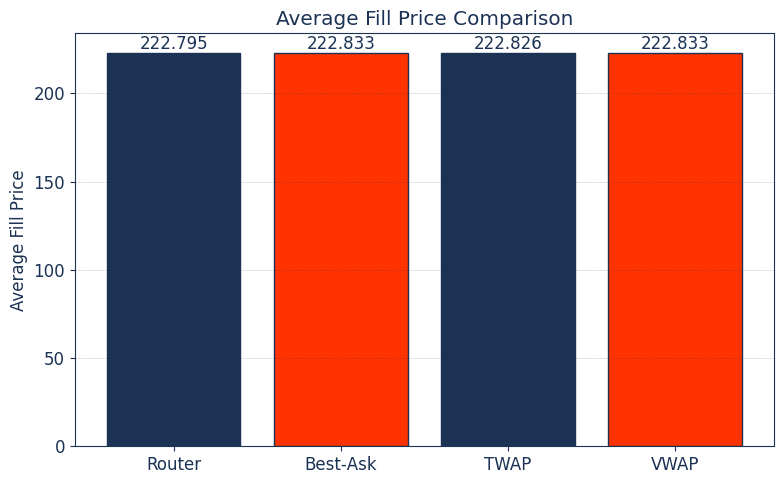

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

blue = "#1b3254"
orange = "#fe3300"

plt.rcParams.update({
    "axes.edgecolor": blue,
    "axes.labelcolor": blue,
    "xtick.color": blue,
    "ytick.color": blue,
    "text.color":   blue,
    "font.size": 12
})

labels = ["Router", "Best‑Ask", "TWAP", "VWAP"]
avg_prices = [
    summary["router_avg_px"],
    summary["bestask_avg_px"],
    summary["twap_avg_px"],
    summary["vwap_avg_px"],
]

bar_colours = [blue if i % 2 == 0 else orange
               for i in range(len(labels))]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, avg_prices, color=bar_colours, edgecolor=blue)

plt.ylabel("Average Fill Price")
plt.title("Average Fill Price Comparison")

for idx, val in enumerate(avg_prices):
    plt.text(idx, val, f"{val:.3f}", ha="center", va="bottom", color=blue)

plt.grid(axis="y", linestyle="--", linewidth=0.4, color=blue, alpha=0.3)

plt.tight_layout()
plt.show()

plt.savefig("results.png")